<a href="https://colab.research.google.com/github/ctarrington/data-science-hw/blob/master/kalman-filters/rlabbe/rlabbe_04_1d_kalman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math

import numpy as np

from scipy.stats import norm

from matplotlib.pyplot import plot
from matplotlib import pyplot as plt

from ipywidgets import fixed, interact
import ipywidgets as widgets

In [2]:
class Gaussian:
  def __init__(self, mean, var, name):
    self.mean = mean
    self.var = var
    self.name = name

    self.rv = norm(mean, var)

  def add(self, other, name):
    return Gaussian(self.mean + other.mean, self.var +other.var, name)

  def multiply(self, other, name):
    mean = (self.var * other.mean + other.var * self.mean) / (self.var + other.var)
    variance = (self.var * other.var) / (self.var + other.var)
    return Gaussian(mean, variance, name)

  def min_plot_value(self):
    return self.mean - 1.5 * self.var

  def max_plot_value(self):
    return self.mean + 1.5 * self.var

  def print(self):
    print('%s: Gaussian(%.2f, %.2f)' % (self.name, self.mean, self.var))

  def pdf(self, xs):
    return self.rv.pdf(xs)


In [16]:
def show_filter_value(actuals, measurements, estimates):
  burn_in = 6
  measurement_error = measurements[burn_in:] - actuals[burn_in:]
  estimate_error = estimates[burn_in:] - actuals[burn_in:]
  estimate_advantage = np.abs(measurement_error) - np.abs(estimate_error)
  mean_advantage = np.mean(estimate_advantage)

  # everything together
  _, subplots = plt.subplots(1,2, figsize=(9, 7), constrained_layout=True)
  subplots[0].plot(actuals, '-b', label='Actuals')
  subplots[0].plot(measurements, 'yo', label='Measurements')
  subplots[0].plot(estimates, '--gx', label='Estimates')
  subplots[0].legend()

  # advantage
  burnt_times = range(burn_in, len(estimates))
  subplots[1].plot(burnt_times, estimate_advantage, 'go')
  subplots[1].set_xlim(left=0)
  subplots[1].hlines(0, burn_in, len(estimates))
  subplots[1].set_title('Mean estimate advantage %.1f' % mean_advantage)
  
  plt.show()

In [4]:
def data_and_noise(x0 = 0, v = 2, a = 0, var = 1, count = 30, seed = 123):
  np.random.seed(seed)

  std = math.sqrt(var)
  xs = np.array([x0 + t * v + 0.5 * a * t ** 2 for t in range(count)])
  noise = np.array(np.random.normal(0, std, count))
  return (xs, xs + noise)

In [5]:
def show_sum(mean1, var1, name1, mean2, var2, name2):
  one = Gaussian(mean1, var1, name1)
  two = Gaussian(mean2, var2, name2)

  sum_name = '%s + %s' % (name1, name2)
  sum = one.add(two, sum_name)

  min_point = min(one.min_plot_value(), two.min_plot_value(), sum.min_plot_value(), 0)
  max_point = max(one.max_plot_value(), two.max_plot_value(), sum.max_plot_value(), 16)

  points = np.arange(min_point, max_point, 0.1)
  plot(points, one.pdf(points), label=name1)
  plot(points, two.pdf(points), label=name2)
  plot(points, sum.pdf(points), label=sum_name)

  plt.legend()
  plt.show()


In [6]:
def show_product(mean1, var1, name1, mean2, var2, name2):
  one = Gaussian(mean1, var1, name1)
  two = Gaussian(mean2, var2, name2)

  product_name = '%s * %s' % (name1, name2)
  product = one.multiply(two, product_name)

  min_point = min(one.min_plot_value(), two.min_plot_value(), product.min_plot_value(), 0)
  max_point = max(one.max_plot_value(), two.max_plot_value(), product.max_plot_value(), 16)

  points = np.arange(min_point, max_point, 0.1)
  plot(points, one.pdf(points), label=name1)
  plot(points, two.pdf(points), label=name2)
  plot(points, product.pdf(points), label=product_name)

  plt.legend()
  plt.show()

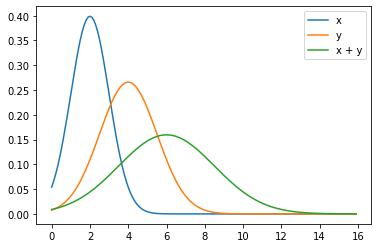

In [7]:
show_sum(2, 1, 'x', 4, 1.5, 'y')

In [8]:
interact(show_sum,
         mean1=widgets.FloatSlider(2, min=0., max=10.),
         var1=widgets.FloatSlider(1, min=0.2, max=3.),
         name1=fixed('x'),
         mean2=widgets.FloatSlider(4, min=0., max=10.),
         var2=widgets.FloatSlider(1.5, min=0.2, max=3.),
         name2=fixed('y'))

interactive(children=(FloatSlider(value=2.0, description='mean1', max=10.0), FloatSlider(value=1.0, descriptio…

<function __main__.show_sum>

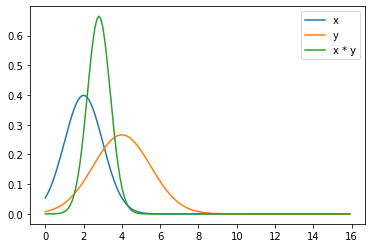

In [9]:
show_product(2, 1, 'x', 4, 1.5, 'y')

In [10]:
interact(show_product,
         mean1=widgets.FloatSlider(2, min=0., max=10.),
         var1=widgets.FloatSlider(1, min=0.2, max=3.),
         name1=fixed('x'),
         mean2=widgets.FloatSlider(4, min=0, max=10.),
         var2=widgets.FloatSlider(1.5, min=0.2, max=3.),
         name2=fixed('y'))

interactive(children=(FloatSlider(value=2.0, description='mean1', max=10.0), FloatSlider(value=1.0, descriptio…

<function __main__.show_product>

In [27]:
velocity = 2
dt = 1

# process variance is in the predicted movement
# sensor variance is in the measurement

def filter_scenario(process_var, sensor_var, x0):
  process_model = Gaussian(velocity*dt, process_var, 'process model')

  actuals, z_measurements = data_and_noise(x0=x0, v=velocity, var=sensor_var)
  x_state = Gaussian(0, 100, 'prior')   # weak prior

  x_values = []
  for z in z_measurements:
    x_predicted = x_state.add(process_model, 'predicted')
    measurement_distribution = Gaussian(z, sensor_var, 'measurement')
    x_state = x_predicted.multiply(measurement_distribution, 'new state')
    x_values.append(x_state.mean)

  show_filter_value(actuals, z_measurements, x_values)

In [28]:
interact(filter_scenario, 
         process_var=widgets.FloatSlider(1, min=0.2, max=10.),
         sensor_var=widgets.FloatSlider(3, min=0.2, max=10),
         x0=widgets.FloatSlider(0, min=0, max=100))

interactive(children=(FloatSlider(value=1.0, description='process_var', max=10.0, min=0.2), FloatSlider(value=…

<function __main__.filter_scenario>